### Quiz II Practice (All His Pop Quizzes)

In [9]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

#### Exercise 1:
*   Plot a square and apply the following transformations to it:
    - Scale factor of 2
    - Shear factor of 0.1
    - 20 Degrees Rotation
    - Translation by [2, 3]
*   Plot the transformed square

In [64]:
originalSquare = np.array([
    [1, 1],
    [-1, 1],
    [-1, -1],
    [1, -1],
    [1, 1]
])

originalSquare.shape                # (5, 2) --> 5 rows, 2 columns 
                                    #   each row is a point, columns are (x, y)
x_axis = originalSquare[:, 0]       # take all rows from the first column of originalSquare (i.e., 1, -1, -1, 1, 1)
y_axis = originalSquare[:, 1]       # take all rows from the second column of originalSquare (i.e., 1, 1, -1, -1, 1)

In [68]:
scaleFactor = 1
shearFactor = 0.1
rotationAngle = np.radians(20)
translationXY = [2, 3]

# Scaling (3 x 3 Matrix)
scaleMatrix = np.array([
    [scaleFactor, 0, 0], 
    [0, scaleFactor, 0],
    [0, 0, 1]
])

# Shearing (3 x 3 Matrix)
shearMatrix = np.array([
    [1, shearFactor, 0],
    [shearFactor, 1, 0],
    [0, 0, 1]
])

# Rotation (3 x 3)
rotationMatrix = np.array([
    [np.cos(rotationAngle), -np.sin(rotationAngle), 0],
    [np.sin(rotationAngle), np.cos(rotationAngle), 0],
    [0, 0, 1]
])

# Translation (3 x 3)
translationMatrix = np.array([
    [1, 0, translationXY[0]],
    [0, 1, translationXY[1]], 
    [0, 0, 1]
])

# Compute the homography matrix
homography_matrix = np.dot(translationMatrix, np.dot(rotationMatrix, np.dot(shearMatrix, scaleMatrix)))

In [69]:
# Apply the homography to each original point
#   Before doing that, we need to add an additional column of 1s to originalSquare because it has 2 columns and homographyMatrix has 3 columns
originalSquare_new = np.column_stack((originalSquare, np.ones(originalSquare.shape[0])))
transformedSquare = np.dot(homography_matrix, originalSquare_new.T)

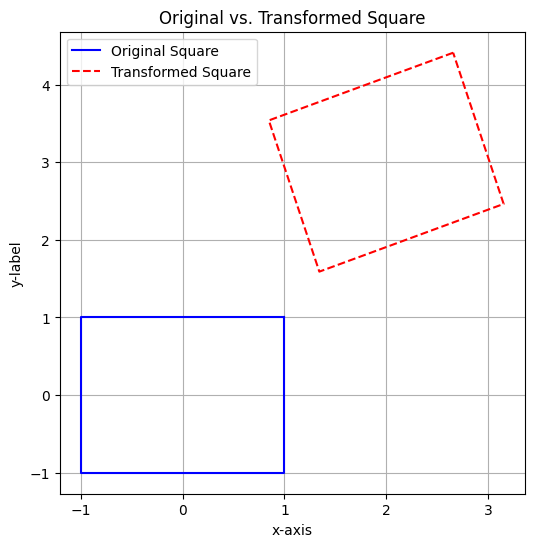

In [74]:
plt.figure(figsize = (6, 6))
plt.title('Original vs. Transformed Square')
plt.xlabel('x-axis')
plt.ylabel('y-label')
plt.grid(True)

x_axis_transformed = transformedSquare.T[:, 0]       # take all rows from the first column of transformedSquare (i.e., 1, -1, -1, 1, 1)
y_axis_transformed = transformedSquare.T[:, 1]       # take all rows from the second column of transformedSquare (i.e., 1, 1, -1, -1, 1)

plt.plot(x_axis, y_axis, label = 'Original Square', color = 'blue')
plt.plot(x_axis_transformed, y_axis_transformed, label = 'Transformed Square', linestyle = 'dashed', color = 'red')
plt.legend()

#### Exercise 2:
*   Using frame.jpg, make the frame straight and print the input/output images
    - Select four points in the following order --> top left, top right, bottom left, bottom right
    - Apply the homography transformation
*   The output image simulates a top-down view of the selected perspective (bordered by the selected four points)

In [3]:
from matplotlib.backend_bases import MouseButton
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

In [4]:
framePNG = cv2.imread('data/images/frame.jpg')
plt.imshow(cv2.cvtColor(framePNG, cv2.COLOR_BGR2RGB))
plt.title('Select Four Points in the Following Order: Top Left, Top Right, Bottom Left, Bottom Right')

selectedPoints = plt.ginput(4, show_clicks = True, mouse_add = MouseButton.LEFT, mouse_pop = MouseButton.RIGHT, mouse_stop = MouseButton.MIDDLE)
plt.close()

In [12]:
inputPoints = np.array(selectedPoints, dtype  = np.float32)

width = (np.linalg.norm(inputPoints[0] - inputPoints[1]), np.linalg.norm(inputPoints[2] - inputPoints[3]))
height = (np.linalg.norm(inputPoints[0] - inputPoints[2]), np.linalg.norm(inputPoints[1] - inputPoints[3]))

width = int(np.max(width))      # assign the bigger width as the width of the transformed image
height = int(np.max(height))    # assign the bigger height as the height of the transformed image

outputPoints = np.array([
    (0, 0),
    (width - 1, 0),
    (0, height - 1),
    (width - 1, height - 1)
], dtype = np.float32)

In [13]:
homography = cv2.getPerspectiveTransform(inputPoints, outputPoints)
straightenedFrame = cv2.warpPerspective(framePNG, homography, (width, height), flags = cv2.INTER_LINEAR)

Text(0.5, 1.0, 'Transformed frame.jpg (Top-Down View)')

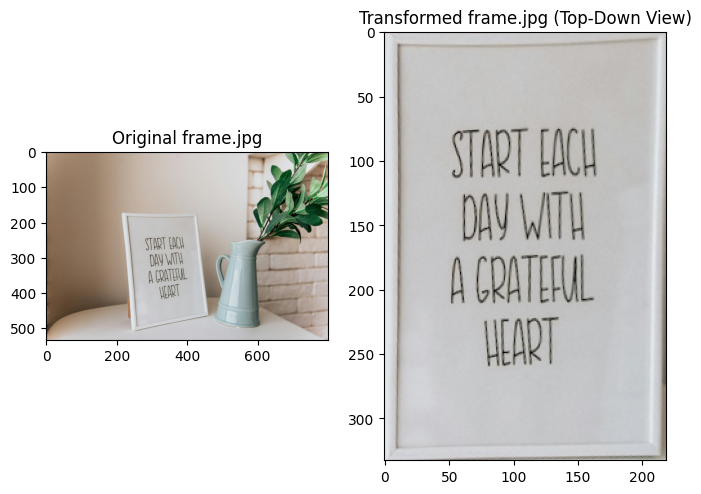

In [17]:
%matplotlib inline
plt.figure(figsize = (8, 8))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(framePNG, cv2.COLOR_BGR2RGB))
plt.title('Original frame.jpg')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(straightenedFrame, cv2.COLOR_BGR2RGB))
plt.title('Transformed frame.jpg (Top-Down View)')

#### Exercise 3:
*   Stitch the images keble.000.png and keble.003.png

In [19]:
keble0 = cv2.imread('data/images/keble.000.png')
keble3 = cv2.imread('data/images/keble.003.png')

# Compute the keypoints and descriptors for each image
SIFT = cv2.SIFT_create()
kp0, des0 = SIFT.detectAndCompute(keble0, None)
kp3, des3 = SIFT.detectAndCompute(keble3, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des0, des3, k = 2)

# Apply a ratio test to get only the good matches
goodMatches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        goodMatches.append(m)

In [35]:
sourcePoints = np.float32( [kp0[m.queryIdx].pt for m in goodMatches] ).reshape(-1, 1, 2)    # we want each pt to be a row with 2 cols (x, y) as a 3D array
destPoints = np.float32( [kp3[m.trainIdx].pt for m in goodMatches] ).reshape(-1, 1, 2)

# Estimate the homography matrix using RANSAC
homography, mask = cv2.findHomography(sourcePoints, destPoints, cv2.RANSAC, ransacReprojThreshold = 5)

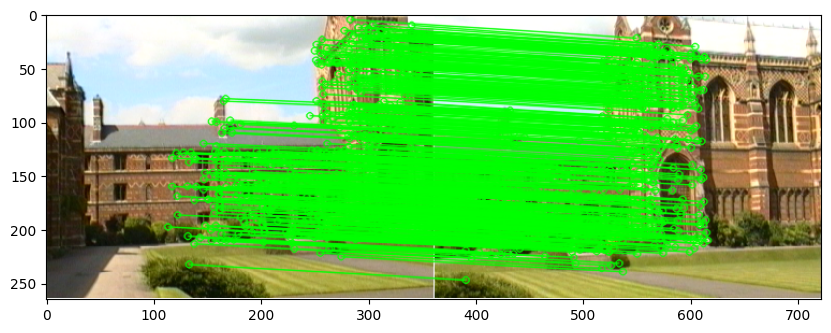

In [36]:
# Draw the matches
plt.figure(figsize = (10, 10))
image_with_matches = cv2.drawMatches(keble0, kp0, keble3, kp3, goodMatches, outImg = None, matchColor = (0, 255, 0), 
                                     singlePointColor = None, matchesMask = mask.ravel().tolist(), flags = 2)
plt.imshow(cv2.cvtColor(image_with_matches, cv2.COLOR_BGR2RGB))

In [37]:
# Stitch the images
height0, width0 = keble0.shape[:2]
height3, width3 = keble3.shape[:2]

corners0 = np.array([
    (0, 0),
    (0, height0 - 1),
    (width0 - 1, height0 - 1),
    (width0 - 1, 0)
], dtype = np.float32).reshape(-1, 1, 2)

corners3 = np.array([
    (0, 0),
    (0, height3 - 1),
    (width3 - 1, height3 - 1),
    (width3 - 1, 0)
], dtype = np.float32).reshape(-1, 1, 2)

In [40]:
transformCorners = cv2.perspectiveTransform(corners0, homography)                     # only corners of keble0 will undergo transformation
transformCorners = np.concatenate((transformCorners, corners3), axis = 0)             # stack them vertically (along the rows)

In [41]:
# Find the minimum and maximum (transformed) coordinates to get the dimensions of the panoramic image
min_x, min_y = np.int32(transformCorners.min(axis = 0).ravel())                                        
max_x, max_y = np.int32(transformCorners.max(axis = 0).ravel())

translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])      # shifting the image by -min_x & min_y

# Apply translation to the original homography
transformation = np.dot(translation_matrix, homography)

In [46]:
# Warp the images
stitchedImage = cv2.warpPerspective(keble0, transformation, (max_x - min_x + 1, max_y - min_y + 1))
stitchedImage[-min_y:keble3.shape[0] - min_y, -min_x:keble3.shape[1] - min_x,:] = keble3

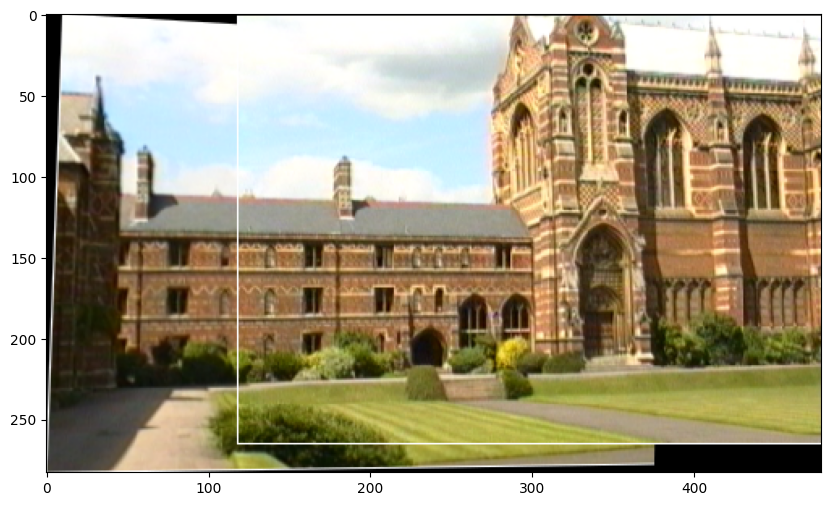

In [47]:
plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(stitchedImage, cv2.COLOR_BGR2RGB))

#### Exercise 4:
*   Find the homography matrix that transforms image1 (checkboard1) to image 2 (checkboard2) and plot the results
*   Use the first 4 points to find H and apply the transformation to the image to compare

In [48]:
image1 = cv2.imread('data/images/checkerboard1.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('data/images/checkerboard2.png', cv2.IMREAD_GRAYSCALE)


pts1 = np.array([[100, 100],[100, 200], [200, 100], [200,200], 
                 [250, 250],[250, 350], [350, 250], [350,350]]).T
pts2 = np.array([(120, 86), (218, 114), (110, 183), (199, 198),
                (229, 242), (292, 251), (223, 275), (283, 281)]).T

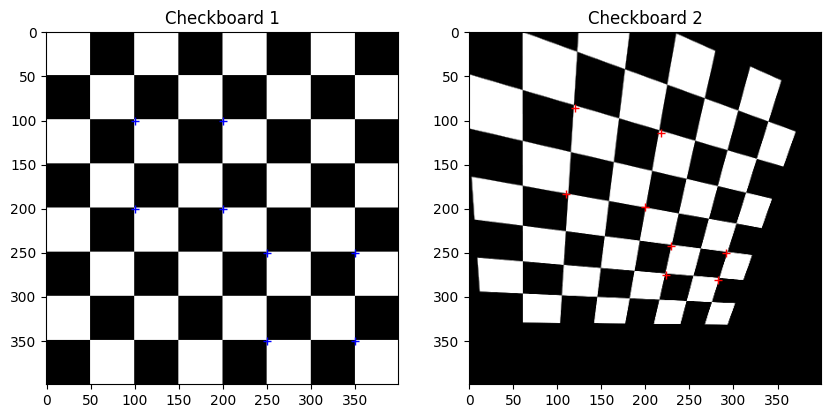

In [55]:
plt.figure(figsize = (10, 10))

plt.subplot(1, 2, 1)
plt.imshow(image1, cmap = 'gray')
plt.title('Checkboard 1')
plt.plot(pts1[0, :], pts1[1, :], 'b+')

plt.subplot(1, 2, 2)
plt.imshow(image2, cmap = 'gray')
plt.title('Checkboard 2')
plt.plot(pts2[0, :], pts2[1, :], 'r+')

In [69]:
input_points = np.array(pts1[:, :4], dtype = np.float32).T              # extract the first four columns from all rows
outputPoints = np.array(pts2[:, :4], dtype = np.float32).T

In [117]:
H = cv2.getPerspectiveTransform(input_points, outputPoints)
_pts1 = cv2.perspectiveTransform(pts1.T.reshape(-1, 1, 2).astype(np.float32), H)        # apply homography to pts1
                                                                                        # you'll have to reshape it because perspectiveTransform    
                                                                                        # expects the points to be a 3D arr??, where each point   
                                                                                        # occupies 1 row and has 2 cols (x, y); -1 -- number of pts = total # of rows
                                                                                        # Note: you can also do pts1.reshape(-1, 2)
                                                                                        #    -1 being the number of points, 2 is the (x, y) coordinates 

Text(0.5, 1.0, 'Transformed Points')

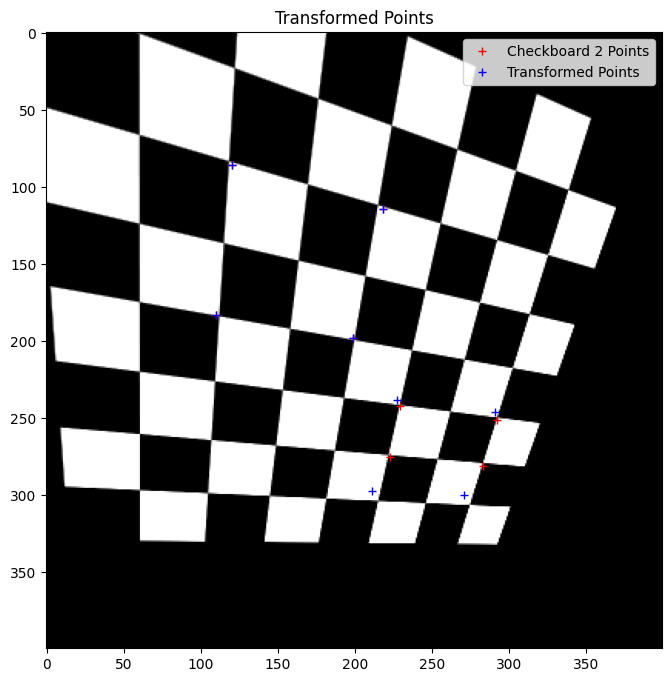

In [118]:
plt.figure(figsize = (8, 8))
plt.imshow(image2, cmap = 'gray')
plt.plot(pts2[0, :], pts2[1, :], 'r+', label = 'Checkboard 2 Points')
plt.plot(_pts1[:, :, 0], _pts1[:, :, 1], 'b+', label = 'Transformed Points')        # _pts1 is a 3D array -- extracting rows and cols of all points
plt.legend()
plt.title('Transformed Points')